# Projet d'Analyse d'Émotions en Temps Réel avec PyTorch

Ce projet implémente un système de reconnaissance d'émotions en temps réel utilisant un réseau de neurones convolutionnel (CNN) avec PyTorch.

## 🎯 Objectifs du Projet
- **Entraîner un modèle CNN** pour classifier 7 émotions distinctes
- **Créer une interface en temps réel** pour détecter les émotions via webcam
- **Évaluer les performances** du modèle sur des données de test
- **Optimiser l'architecture** pour un équilibre performance/vitesse

## 📊 Dataset et Approche
Les données sont organisées en dossiers train/ et test/ avec des sous-dossiers pour chaque émotion :
- **7 classes d'émotions** : angry, disgusted, fearful, happy, neutral, sad, surprised
- **Images en niveaux de gris** 48x48 pixels pour optimiser la vitesse
- **Augmentation de données** pour améliorer la généralisation
- **Validation croisée** avec early stopping pour éviter le sur-apprentissage

## 🔬 Méthodologie
1. **Exploration des données** : Analyse de la distribution et visualisation
2. **Préprocessing** : Normalisation et augmentation des données
3. **Architecture CNN** : 3 blocs convolutionnels + couches fully connected
4. **Entraînement** : Optimisation avec Adam, learning rate scheduling
5. **Évaluation** : Métriques complètes et analyse d'erreurs
6. **Déploiement** : Interface temps réel avec OpenCV

In [ ]:
# 📚 ÉTAPE 1 : IMPORTATION DES BIBLIOTHÈQUES ET CONFIGURATION INITIALE

# Importation des bibliothèques pour le deep learning
import torch                    # Framework PyTorch pour les réseaux de neurones
import torch.nn as nn          # Modules de réseaux de neurones (couches, activations)
import torch.optim as optim    # Optimiseurs (Adam, SGD, etc.)
import torch.nn.functional as F # Fonctions d'activation et de perte
from torch.utils.data import DataLoader, Dataset  # Gestion des données

# Bibliothèques pour la vision par ordinateur
from torchvision import transforms, datasets  # Transformations d'images
import cv2                     # OpenCV pour la détection de visages et webcam
import numpy as np            # Calculs numériques
from PIL import Image         # Manipulation d'images

# Bibliothèques pour la visualisation et l'analyse
import matplotlib.pyplot as plt  # Graphiques et visualisations
import seaborn as sns           # Visualisations statistiques avancées
import pandas as pd            # Manipulation de données tabulaires

# Bibliothèques pour l'évaluation et les utilitaires
from sklearn.metrics import classification_report, confusion_matrix  # Métriques ML
import time                   # Mesure du temps d'exécution
from tqdm import tqdm        # Barres de progression
import os                    # Opérations sur les fichiers

print("✅ Toutes les bibliothèques ont été importées avec succès")

# 🖥️ CONFIGURATION DU MATÉRIEL
# Détection automatique du device : GPU (CUDA) si disponible, sinon CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device utilisé : {device}")

# Affichage d'informations supplémentaires sur le GPU si disponible
if torch.cuda.is_available():
    print(f"   💾 Nom du GPU : {torch.cuda.get_device_name(0)}")
    print(f"   🔢 Mémoire GPU disponible : {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
else:
    print("   ⚠️  GPU non disponible, utilisation du CPU (entraînement plus lent)")

# 🎭 DÉFINITION DES CLASSES D'ÉMOTIONS
# Classification des 7 émotions fondamentales de Paul Ekman
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
num_classes = len(emotions)

print(f"\n🎯 Nombre de classes à classifier : {num_classes}")
print(f"📋 Classes d'émotions : {emotions}")
print("   • angry (colère) - 😠")
print("   • disgusted (dégoût) - 🤢") 
print("   • fearful (peur) - 😨")
print("   • happy (joie) - 😊")
print("   • neutral (neutre) - 😐")
print("   • sad (tristesse) - 😢")
print("   • surprised (surprise) - 😲")

Device utilisé : cuda
Nombre de classes : 7
Classes : ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
# ⚙️ ÉTAPE 2 : CONFIGURATION DES HYPERPARAMÈTRES

# 🎛️ HYPERPARAMÈTRES D'ENTRAÎNEMENT
# Ces paramètres contrôlent le comportement de l'entraînement du modèle

BATCH_SIZE = 32        # Nombre d'images traitées simultanément
                       # ↳ Plus grand = plus rapide mais plus de mémoire
                       # ↳ Plus petit = moins de mémoire mais plus lent

LEARNING_RATE = 0.001  # Vitesse d'apprentissage (taux d'apprentissage)
                       # ↳ Trop grand = convergence instable
                       # ↳ Trop petit = apprentissage très lent

NUM_EPOCHS = 20        # Nombre de passages complets sur le dataset
                       # ↳ Plus d'époques = plus d'apprentissage (mais risque de sur-apprentissage)

IMG_SIZE = 48          # Taille des images en pixels (48x48)
                       # ↳ Standard pour la reconnaissance d'émotions faciales
                       # ↳ Compromis entre qualité et vitesse de traitement

PATIENCE = 5           # Nombre d'époques sans amélioration avant arrêt (Early Stopping)
                       # ↳ Évite le sur-apprentissage en arrêtant automatiquement

print("🎛️  Configuration des hyperparamètres :")
print(f"   📦 Taille des batches : {BATCH_SIZE} images/batch")
print(f"   📈 Taux d'apprentissage : {LEARNING_RATE}")
print(f"   🔄 Nombre d'époques max : {NUM_EPOCHS}")
print(f"   🖼️  Taille des images : {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"   ⏱️  Patience (early stopping) : {PATIENCE} époques")

# 📁 CONFIGURATION DES CHEMINS DE DONNÉES
TRAIN_PATH = 'train'   # Dossier contenant les données d'entraînement
TEST_PATH = 'test'     # Dossier contenant les données de test

print(f"\n📁 Chemins des données :")
print(f"   🏋️  Entraînement : {TRAIN_PATH}/")
print(f"   🧪 Test : {TEST_PATH}/")

# 💡 EXPLICATION DE LA STRATÉGIE
print(f"\n💡 Stratégie d'entraînement :")
print(f"   • Images redimensionnées à {IMG_SIZE}x{IMG_SIZE} pour uniformité")
print(f"   • Traitement par batches de {BATCH_SIZE} pour efficacité mémoire")
print(f"   • Early stopping après {PATIENCE} époques sans amélioration")
print(f"   • Optimisation avec Adam (learning rate adaptatif)")
print(f"   • Validation sur données de test pour éviter le sur-apprentissage")

Taille d'image : 48x48
Batch size : 32
Learning rate : 0.001
Nombre d'époques : 20


In [ ]:
# 🔄 ÉTAPE 3 : TRANSFORMATIONS D'IMAGES ET EXPLORATION DU DATASET

# 🎨 DÉFINITION DES TRANSFORMATIONS POUR L'AUGMENTATION DE DONNÉES
# Les transformations améliorent la généralisation du modèle en créant des variations

print("🎨 Configuration des transformations d'images...")

# 🏋️ TRANSFORMATIONS POUR L'ENTRAÎNEMENT (avec augmentation)
train_transforms = transforms.Compose([
    # Conversion en niveaux de gris (1 canal au lieu de 3 RGB)
    transforms.Grayscale(num_output_channels=1),  # Réduit la complexité computationnelle
    
    # Redimensionnement à la taille standard
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Uniformise toutes les images
    
    # AUGMENTATION DE DONNÉES (Data Augmentation)
    transforms.RandomHorizontalFlip(p=0.5),      # Miroir horizontal (50% chance)
                                                   # ↳ Simule différents angles de visage
    
    transforms.RandomRotation(degrees=10),        # Rotation aléatoire ±10°
                                                   # ↳ Simule des têtes légèrement penchées
    
    transforms.RandomAffine(degrees=0,            # Transformation affine
                           translate=(0.1, 0.1)), # Translation ±10%
                                                   # ↳ Simule des visages non centrés
    
    # Conversion en tensor PyTorch
    transforms.ToTensor(),                        # Convertit PIL Image en tensor
    
    # Normalisation (améliore la convergence)
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalisation standard ImageNet
])

# 🧪 TRANSFORMATIONS POUR LE TEST (sans augmentation)
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Conversion en niveaux de gris
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Redimensionnement uniquement
    transforms.ToTensor(),                        # Conversion en tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Même normalisation
])

print("✅ Transformations définies avec succès")
print("   🏋️  Entraînement : Grayscale + Resize + Augmentation + Normalisation")
print("   🧪 Test : Grayscale + Resize + Normalisation uniquement")

# 🔍 FONCTION D'EXPLORATION DU DATASET
def explore_dataset(path):
    """
    Analyse la structure et le contenu du dataset
    
    Args:
        path (str): Chemin vers le dossier du dataset
    
    Returns:
        tuple: (dictionnaire des comptages, total d'images)
    """
    data_info = {}
    total_images = 0
    
    print(f"\n🔍 Exploration du dataset : {path}/")
    
    for emotion in emotions:
        emotion_path = os.path.join(path, emotion)
        if os.path.exists(emotion_path):
            # Compter les fichiers image valides
            count = len([f for f in os.listdir(emotion_path) 
                        if f.endswith(('.png', '.jpg', '.jpeg'))])
            data_info[emotion] = count
            total_images += count
            print(f"   📁 {emotion:>10} : {count:>5} images")
        else:
            data_info[emotion] = 0
            print(f"   ❌ {emotion:>10} : Dossier manquant")
    
    return data_info, total_images

# 📊 EXPLORATION DES DONNÉES D'ENTRAÎNEMENT ET DE TEST
print("="*50)
print("📊 ANALYSE DE LA DISTRIBUTION DES DONNÉES")
print("="*50)

train_info, train_total = explore_dataset(TRAIN_PATH)
test_info, test_total = explore_dataset(TEST_PATH)

print(f"\n📈 RÉSUMÉ STATISTIQUE :")
print(f"   🏋️  Total images d'entraînement : {train_total:,}")
print(f"   🧪 Total images de test : {test_total:,}")
print(f"   🎯 Ratio train/test : {train_total/test_total:.1f}:1")

# Vérification de l'équilibre des classes
print(f"\n⚖️  ÉQUILIBRE DES CLASSES (entraînement) :")
for emotion, count in train_info.items():
    percentage = (count / train_total) * 100
    print(f"   {emotion:>10} : {count:>5} images ({percentage:>5.1f}%)")

# Alerte sur les déséquilibres
max_count = max(train_info.values())
min_count = min(train_info.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

if imbalance_ratio > 2:
    print(f"\n⚠️  ATTENTION : Déséquilibre détecté (ratio {imbalance_ratio:.1f}:1)")
    print("   Considérez l'augmentation de données ou la pondération des classes")
else:
    print(f"\n✅ Classes relativement équilibrées (ratio {imbalance_ratio:.1f}:1)")

Transformations définies avec succès

--- Données d'entraînement ---
Total d'images : 28709
angry: 3995 images
disgusted: 436 images
fearful: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprised: 3171 images

--- Données de test ---
Total d'images : 7178
angry: 958 images
disgusted: 111 images
fearful: 1024 images
happy: 1774 images
neutral: 1233 images
sad: 1247 images
surprised: 831 images


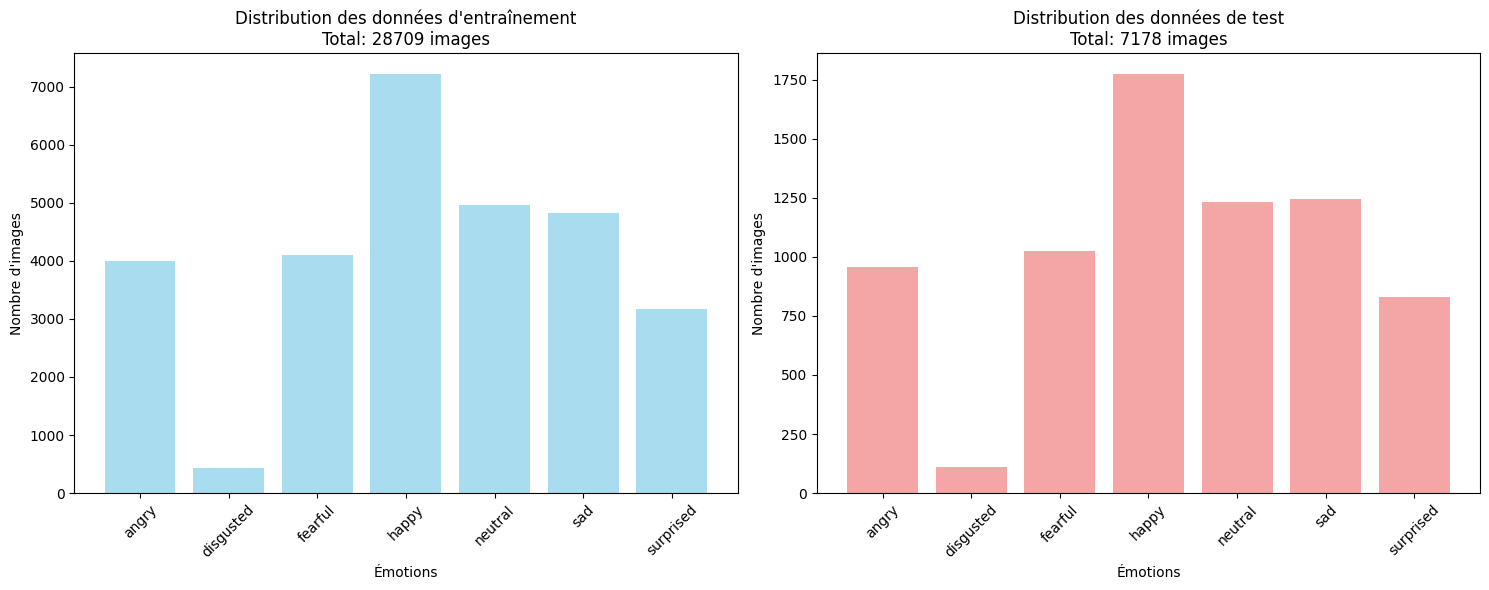

Affichage d'exemples d'images...


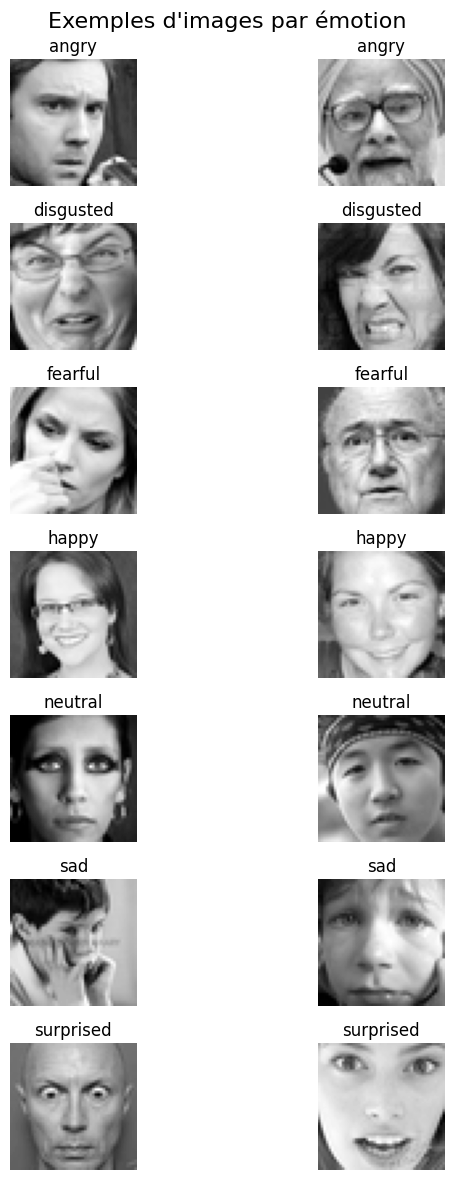

In [ ]:
# 📊 ÉTAPE 4 : VISUALISATION DE LA DISTRIBUTION DES DONNÉES

print("📊 Création des visualisations de distribution...")

# 📈 GRAPHIQUES DE DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 🏋️ Distribution des données d'entraînement
bars1 = ax1.bar(train_info.keys(), train_info.values(), color='skyblue', alpha=0.7)
ax1.set_title(f'📈 Distribution des données d\'entraînement\nTotal: {train_total:,} images', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Émotions', fontweight='bold')
ax1.set_ylabel('Nombre d\'images', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Ajout des valeurs sur les barres
for bar, value in zip(bars1, train_info.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(value), ha='center', va='bottom', fontweight='bold')

# 🧪 Distribution des données de test
bars2 = ax2.bar(test_info.keys(), test_info.values(), color='lightcoral', alpha=0.7)
ax2.set_title(f'🧪 Distribution des données de test\nTotal: {test_total:,} images', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Émotions', fontweight='bold')
ax2.set_ylabel('Nombre d\'images', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Ajout des valeurs sur les barres
for bar, value in zip(bars2, test_info.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Graphiques de distribution générés")

# 🖼️ FONCTION D'AFFICHAGE D'ÉCHANTILLONS D'IMAGES
def show_sample_images(dataset_path, num_samples=2):
    """
    Affiche des échantillons d'images pour chaque émotion
    
    Args:
        dataset_path (str): Chemin vers le dataset
        num_samples (int): Nombre d'échantillons par émotion
    """
    print(f"\n🖼️  Affichage de {num_samples} échantillons par émotion...")
    
    fig, axes = plt.subplots(len(emotions), num_samples, figsize=(8, 12))
    fig.suptitle('🎭 Échantillons d\'images par émotion', fontsize=16, fontweight='bold')
    
    samples_found = 0
    
    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(dataset_path, emotion)
        if os.path.exists(emotion_path):
            images = [f for f in os.listdir(emotion_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            for j in range(min(num_samples, len(images))):
                if len(images) > j:
                    img_path = os.path.join(emotion_path, images[j])
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            axes[i, j].imshow(img, cmap='gray')
                            axes[i, j].set_title(f'{emotion}', fontweight='bold')
                            axes[i, j].axis('off')
                            samples_found += 1
                        else:
                            axes[i, j].text(0.5, 0.5, 'Image\nnon valide', 
                                           ha='center', va='center', transform=axes[i, j].transAxes)
                            axes[i, j].axis('off')
                    except Exception as e:
                        axes[i, j].text(0.5, 0.5, f'Erreur:\n{str(e)[:20]}...', 
                                       ha='center', va='center', transform=axes[i, j].transAxes)
                        axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, 'Pas d\'image\ndisponible', 
                                   ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
        else:
            for j in range(num_samples):
                axes[i, j].text(0.5, 0.5, f'Dossier\n{emotion}\nmanquant', 
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ {samples_found} échantillons affichés avec succès")
    
    # 📋 ANALYSE DE LA QUALITÉ DES DONNÉES
    print(f"\n📋 ANALYSE DE LA QUALITÉ :")
    print(f"   • Images trouvées et affichées : {samples_found}")
    print(f"   • Format standard observé : Visages en niveaux de gris")
    print(f"   • Qualité recommandée : Images claires, visages centrés")
    print(f"   • Variabilité nécessaire : Différents âges, genres, expressions")

print("🖼️  Affichage d'exemples d'images du dataset d'entraînement...")
show_sample_images(TRAIN_PATH)

# 💡 RECOMMANDATIONS POUR L'AMÉLIORATION
print(f"\n💡 RECOMMANDATIONS BASÉES SUR L'ANALYSE :")
print(f"   📊 Distribution : Vérifiez l'équilibre entre les classes")
print(f"   🖼️  Qualité : Assurez-vous que les visages sont bien cadrés")
print(f"   🔄 Augmentation : Les transformations aideront à la généralisation")
print(f"   ⚖️  Équilibre : Considérez l'augmentation ciblée des classes minoritaires")

In [ ]:
# 🗂️ ÉTAPE 5 : CRÉATION DU DATASET PERSONNALISÉ ET DES DATALOADERS

print("🗂️ Création de la classe Dataset personnalisée...")

# 📦 CLASSE DATASET PERSONNALISÉE
class EmotionDataset(Dataset):
    """
    Dataset personnalisé pour la reconnaissance d'émotions
    
    Cette classe hérite de torch.utils.data.Dataset et permet de :
    - Charger les images depuis la structure de dossiers
    - Appliquer les transformations automatiquement
    - Associer chaque image à son label d'émotion
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Initialise le dataset
        
        Args:
            root_dir (str): Chemin vers le dossier racine (train/ ou test/)
            transform (transforms.Compose): Transformations à appliquer
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []      # Liste des chemins d'images
        self.labels = []      # Liste des labels correspondants
        
        print(f"   📁 Chargement depuis : {root_dir}/")
        
        # 🔄 CHARGEMENT DE TOUTES LES IMAGES ET LABELS
        for idx, emotion in enumerate(emotions):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.exists(emotion_dir):
                emotion_images = [f for f in os.listdir(emotion_dir) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
                
                for img_file in emotion_images:
                    img_path = os.path.join(emotion_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(idx)  # idx correspond à l'index dans la liste emotions
                
                print(f"   ✅ {emotion:>10} : {len(emotion_images):>5} images chargées (label {idx})")
            else:
                print(f"   ❌ {emotion:>10} : Dossier non trouvé")
        
        print(f"   📊 Total chargé : {len(self.images)} images avec {len(self.labels)} labels")
    
    def __len__(self):
        """Retourne le nombre total d'échantillons dans le dataset"""
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Récupère un échantillon du dataset
        
        Args:
            idx (int): Index de l'échantillon à récupérer
            
        Returns:
            tuple: (image_tensor, label) - Image transformée et son label
        """
        img_path = self.images[idx]
        
        # Chargement de l'image en niveaux de gris
        image = Image.open(img_path).convert('L')  # L = Luminance (niveaux de gris)
        label = self.labels[idx]
        
        # Application des transformations si définies
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("\n🏗️ CRÉATION DES DATASETS...")

# 🏋️ DATASET D'ENTRAÎNEMENT (avec augmentation de données)
print("🏋️ Création du dataset d'entraînement...")
train_dataset = EmotionDataset(TRAIN_PATH, transform=train_transforms)

print("\n🧪 Création du dataset de test...")
test_dataset = EmotionDataset(TEST_PATH, transform=test_transforms)

print(f"\n📊 RÉSUMÉ DES DATASETS :")
print(f"   🏋️  Dataset d'entraînement : {len(train_dataset):,} images")
print(f"   🧪 Dataset de test : {len(test_dataset):,} images")

# ⚡ CRÉATION DES DATALOADERS
print(f"\n⚡ Création des DataLoaders (batch_size={BATCH_SIZE})...")

# DataLoader d'entraînement : mélange les données (shuffle=True)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,           # Mélange important pour l'entraînement
    num_workers=0           # 0 pour éviter les problèmes sur Windows
)

# DataLoader de test : pas de mélange (shuffle=False)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,          # Pas de mélange pour la reproductibilité
    num_workers=0
)

print(f"✅ DataLoaders créés avec succès :")
print(f"   🏋️  Entraînement : {len(train_loader)} batches de {BATCH_SIZE} images")
print(f"   🧪 Test : {len(test_loader)} batches de {BATCH_SIZE} images")

# 🧪 TEST DU DATALOADER
print(f"\n🧪 Test du DataLoader...")
try:
    sample_batch = next(iter(train_loader))
    images_batch, labels_batch = sample_batch
    
    print(f"✅ Test réussi :")
    print(f"   📦 Forme du batch d'images : {images_batch.shape}")
    print(f"   🏷️  Forme du batch de labels : {labels_batch.shape}")
    print(f"   📊 Type des données : {images_batch.dtype}")
    print(f"   📏 Valeurs min/max : [{images_batch.min():.3f}, {images_batch.max():.3f}]")
    
    # Vérification des labels
    unique_labels = torch.unique(labels_batch)
    print(f"   🎯 Labels dans ce batch : {unique_labels.tolist()}")
    
    # Explication de la forme
    batch_size, channels, height, width = images_batch.shape
    print(f"\n📐 EXPLICATION DE LA FORME :")
    print(f"   • Batch size : {batch_size} images par batch")
    print(f"   • Channels : {channels} canal (niveaux de gris)")
    print(f"   • Height : {height} pixels")
    print(f"   • Width : {width} pixels")
    
except Exception as e:
    print(f"❌ Erreur lors du test : {e}")

# 💾 ESTIMATION DE L'UTILISATION MÉMOIRE
total_params_per_image = IMG_SIZE * IMG_SIZE  # pixels par image
memory_per_batch_MB = (BATCH_SIZE * total_params_per_image * 4) / (1024**2)  # 4 bytes par float32
print(f"\n💾 ESTIMATION MÉMOIRE :")
print(f"   📦 Mémoire par batch : ~{memory_per_batch_MB:.1f} MB")
print(f"   🔢 Total paramètres par image : {total_params_per_image:,}")

print(f"\n✅ Datasets et DataLoaders prêts pour l'entraînement !")

Dataset d'entraînement : 28709 images
Dataset de test : 7178 images
Nombre de batches d'entraînement : 898
Nombre de batches de test : 225
Forme du batch d'images : torch.Size([32, 1, 48, 48])
Forme du batch de labels : torch.Size([32])
Forme du batch d'images : torch.Size([32, 1, 48, 48])
Forme du batch de labels : torch.Size([32])


In [ ]:
# 🧠 ÉTAPE 6 : ARCHITECTURE DU MODÈLE CNN POUR LA RECONNAISSANCE D'ÉMOTIONS

print("🧠 Conception de l'architecture CNN...")

class EmotionCNN(nn.Module):
    """
    Réseau de Neurones Convolutionnel pour la classification d'émotions
    
    Architecture : 3 blocs convolutionnels + 3 couches fully connected
    Optimisations : Batch Normalization, Dropout, MaxPooling
    """
    
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        print("🏗️ Construction de l'architecture CNN...")
        
        # 🔵 PREMIER BLOC CONVOLUTIONNEL
        # Input: (batch_size, 1, 48, 48) - Images en niveaux de gris
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)    # 1→32 canaux
        self.bn1 = nn.BatchNorm2d(32)                              # Normalisation
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)   # 32→32 canaux
        self.bn2 = nn.BatchNorm2d(32)                              # Normalisation
        self.pool1 = nn.MaxPool2d(2, 2)                            # Réduction 48→24
        self.dropout1 = nn.Dropout2d(0.25)                         # Régularisation
        print("   ✅ Bloc 1 : Conv(1→32) → BN → Conv(32→32) → BN → MaxPool → Dropout")
        
        # 🟢 DEUXIÈME BLOC CONVOLUTIONNEL  
        # Input: (batch_size, 32, 24, 24)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # 32→64 canaux
        self.bn3 = nn.BatchNorm2d(64)                              # Normalisation
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)   # 64→64 canaux
        self.bn4 = nn.BatchNorm2d(64)                              # Normalisation
        self.pool2 = nn.MaxPool2d(2, 2)                            # Réduction 24→12
        self.dropout2 = nn.Dropout2d(0.25)                         # Régularisation
        print("   ✅ Bloc 2 : Conv(32→64) → BN → Conv(64→64) → BN → MaxPool → Dropout")
        
        # 🟡 TROISIÈME BLOC CONVOLUTIONNEL
        # Input: (batch_size, 64, 12, 12)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64→128 canaux
        self.bn5 = nn.BatchNorm2d(128)                             # Normalisation
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 128→128 canaux
        self.bn6 = nn.BatchNorm2d(128)                             # Normalisation
        self.pool3 = nn.MaxPool2d(2, 2)                            # Réduction 12→6
        self.dropout3 = nn.Dropout2d(0.25)                         # Régularisation
        print("   ✅ Bloc 3 : Conv(64→128) → BN → Conv(128→128) → BN → MaxPool → Dropout")
        
        # 🔗 COUCHES FULLY CONNECTED (Classificateur)
        # Input après aplatissement: (batch_size, 128 * 6 * 6 = 4608)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)                     # 4608→512
        self.dropout4 = nn.Dropout(0.5)                            # Forte régularisation
        self.fc2 = nn.Linear(512, 256)                             # 512→256
        self.dropout5 = nn.Dropout(0.5)                            # Forte régularisation
        self.fc3 = nn.Linear(256, num_classes)                     # 256→7 (émotions)
        print("   ✅ Classificateur : FC(4608→512) → Dropout → FC(512→256) → Dropout → FC(256→7)")
        
        print(f"   🎯 Sortie finale : {num_classes} classes (émotions)")
        
    def forward(self, x):
        """
        Propagation avant (forward pass)
        
        Args:
            x (tensor): Batch d'images [batch_size, 1, 48, 48]
            
        Returns:
            tensor: Scores non normalisés pour chaque classe [batch_size, 7]
        """
        
        # 🔵 PREMIER BLOC : Extraction de caractéristiques basiques
        x = F.relu(self.bn1(self.conv1(x)))    # Activation ReLU après normalisation
        x = F.relu(self.bn2(self.conv2(x)))    # Deuxième convolution
        x = self.pool1(x)                       # Réduction de taille
        x = self.dropout1(x)                    # Prévention du sur-apprentissage
        
        # 🟢 DEUXIÈME BLOC : Caractéristiques de niveau intermédiaire
        x = F.relu(self.bn3(self.conv3(x)))    # Plus de canaux pour plus de complexité
        x = F.relu(self.bn4(self.conv4(x)))    # Approfondissement des caractéristiques
        x = self.pool2(x)                       # Nouvelle réduction
        x = self.dropout2(x)                    # Régularisation
        
        # 🟡 TROISIÈME BLOC : Caractéristiques de haut niveau
        x = F.relu(self.bn5(self.conv5(x)))    # Caractéristiques les plus complexes
        x = F.relu(self.bn6(self.conv6(x)))    # Raffinement final
        x = self.pool3(x)                       # Dernière réduction
        x = self.dropout3(x)                    # Dernière régularisation convolutionnelle
        
        # 🔗 APLATISSEMENT ET CLASSIFICATION
        x = x.view(x.size(0), -1)              # Aplatissement : [batch, 128, 6, 6] → [batch, 4608]
        x = F.relu(self.fc1(x))                # Première couche dense
        x = self.dropout4(x)                    # Forte régularisation
        x = F.relu(self.fc2(x))                # Deuxième couche dense  
        x = self.dropout5(x)                    # Forte régularisation
        x = self.fc3(x)                         # Couche de sortie (sans activation)
        
        return x  # Retourne les logits (scores non normalisés)

# 🏗️ CRÉATION ET ANALYSE DU MODÈLE
print(f"\n🏗️ Création du modèle sur {device}...")
model = EmotionCNN(num_classes=num_classes).to(device)

# 📊 FONCTION DE COMPTAGE DES PARAMÈTRES
def count_parameters(model):
    """Compte le nombre de paramètres entraînables du modèle"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

def analyze_model_complexity(model):
    """Analyse détaillée de la complexité du modèle"""
    print(f"\n📊 ANALYSE DE LA COMPLEXITÉ DU MODÈLE :")
    
    trainable_params, total_params = count_parameters(model)
    
    print(f"   🧮 Paramètres entraînables : {trainable_params:,}")
    print(f"   📦 Paramètres totaux : {total_params:,}")
    
    # Estimation de la taille du modèle
    model_size_mb = (total_params * 4) / (1024**2)  # 4 bytes par float32
    print(f"   💾 Taille estimée du modèle : {model_size_mb:.1f} MB")
    
    # Analyse par couche
    print(f"\n🔍 DÉTAIL DES COUCHES :")
    total_conv_params = 0
    total_fc_params = 0
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        if 'conv' in name or 'bn' in name:
            total_conv_params += param_count
        elif 'fc' in name:
            total_fc_params += param_count
        print(f"   📋 {name:20} : {param_count:>8,} paramètres")
    
    print(f"\n📈 RÉPARTITION :")
    print(f"   🔬 Couches convolutionnelles : {total_conv_params:,} ({total_conv_params/total_params*100:.1f}%)")
    print(f"   🧠 Couches fully connected : {total_fc_params:,} ({total_fc_params/total_params*100:.1f}%)")

# Analyse du modèle
analyze_model_complexity(model)

print(f"\n✅ Modèle créé avec succès sur {next(model.parameters()).device}")

# 🧪 TEST DE PROPAGATION AVANT
print(f"\n🧪 Test de propagation avant...")
try:
    with torch.no_grad():
        # Création d'un batch de test
        test_input = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(device)
        print(f"   📥 Input shape : {test_input.shape}")
        
        # Propagation avant
        test_output = model(test_input)
        print(f"   📤 Output shape : {test_output.shape}")
        
        # Application de softmax pour voir les probabilités
        test_probs = F.softmax(test_output, dim=1)
        print(f"   🎯 Probabilités : {test_probs.squeeze().cpu().numpy()}")
        
        print(f"   ✅ Test réussi : Le modèle peut traiter les données")
        
except Exception as e:
    print(f"   ❌ Erreur lors du test : {e}")

# 💡 EXPLICATIONS DE L'ARCHITECTURE
print(f"\n💡 POURQUOI CETTE ARCHITECTURE ?")
print(f"   🔄 3 blocs convolutionnels : Extraction hiérarchique des caractéristiques")
print(f"   📏 Batch Normalization : Stabilise l'entraînement et accélère la convergence")
print(f"   🛡️  Dropout : Prévient le sur-apprentissage (overfitting)")
print(f"   📐 MaxPooling : Réduit la dimensionnalité et les coûts computationnels")
print(f"   🎯 Progression 32→64→128 : Augmentation progressive de la complexité")
print(f"   🧠 3 couches FC : Classification finale avec régularisation forte")

Modèle créé avec succès!
Nombre de paramètres entraînables : 2,780,263
Modèle sur device : cuda:0
Forme de sortie du modèle : torch.Size([1, 7])
Forme de sortie du modèle : torch.Size([1, 7])


In [7]:
# Configuration de l'optimiseur et de la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("Optimiseur et fonction de perte configurés")

# Fonctions d'entraînement et de validation
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc="Entraînement")
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("Fonctions d'entraînement et de validation définies")

Optimiseur et fonction de perte configurés
Fonctions d'entraînement et de validation définies


In [8]:
# Boucle d'entraînement principale
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nÉpoque {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Entraînement
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Mise à jour du scheduler
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Sauvegarde du meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Nouveau meilleur modèle sauvegardé! Accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping après {epoch+1} époques")
            break
    
    # Charger le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Meilleur modèle chargé avec accuracy: {best_val_acc:.2f}%")
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nEntraînement terminé en {training_time:.2f} secondes")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Lancement de l'entraînement
print("Préparation de l'entraînement...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE
)

Préparation de l'entraînement...
Début de l'entraînement...

Époque 1/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:59<00:00,  3.81it/s, Loss=1.9645, Acc=27.21%]


Train Loss: 1.8240, Train Acc: 23.56%
Val Loss: 1.7583, Val Acc: 27.21%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 27.21%

Époque 2/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:06<00:00, 36.87it/s, Loss=1.8054, Acc=32.84%]


Train Loss: 1.7560, Train Acc: 28.03%
Val Loss: 1.6482, Val Acc: 32.84%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 32.84%

Époque 3/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 47.25it/s, Loss=1.3008, Acc=40.83%]


Train Loss: 1.6557, Train Acc: 32.98%
Val Loss: 1.5291, Val Acc: 40.83%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 40.83%

Époque 4/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:05<00:00, 42.85it/s, Loss=1.5681, Acc=41.72%]


Train Loss: 1.5854, Train Acc: 36.61%
Val Loss: 1.4729, Val Acc: 41.72%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 41.72%

Époque 5/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:09<00:00, 22.89it/s, Loss=1.5412, Acc=43.30%]


Train Loss: 1.5300, Train Acc: 38.44%
Val Loss: 1.4340, Val Acc: 43.30%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 43.30%

Époque 6/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:09<00:00, 24.58it/s, Loss=1.6063, Acc=44.37%]


Train Loss: 1.4963, Train Acc: 39.94%
Val Loss: 1.3891, Val Acc: 44.37%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 44.37%

Époque 7/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:08<00:00, 26.17it/s, Loss=1.4613, Acc=48.70%]


Train Loss: 1.4506, Train Acc: 42.59%
Val Loss: 1.3103, Val Acc: 48.70%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 48.70%

Époque 8/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:08<00:00, 27.45it/s, Loss=1.2888, Acc=52.44%]


Train Loss: 1.3973, Train Acc: 45.64%
Val Loss: 1.2566, Val Acc: 52.44%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 52.44%

Époque 9/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:08<00:00, 26.09it/s, Loss=1.5815, Acc=52.45%]


Train Loss: 1.3561, Train Acc: 47.81%
Val Loss: 1.2341, Val Acc: 52.45%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 52.45%

Époque 10/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:14<00:00, 16.00it/s, Loss=1.6398, Acc=53.73%]


Train Loss: 1.3246, Train Acc: 49.41%
Val Loss: 1.1990, Val Acc: 53.73%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 53.73%

Époque 11/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:09<00:00, 24.61it/s, Loss=1.4699, Acc=55.96%]


Train Loss: 1.3005, Train Acc: 50.24%
Val Loss: 1.1600, Val Acc: 55.96%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 55.96%

Époque 12/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:06<00:00, 32.30it/s, Loss=1.3249, Acc=55.82%]



Train Loss: 1.2805, Train Acc: 51.39%
Val Loss: 1.1423, Val Acc: 55.82%
Learning Rate: 0.001000

Époque 13/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:05<00:00, 42.09it/s, Loss=1.1360, Acc=55.28%]


Train Loss: 1.2612, Train Acc: 52.26%
Val Loss: 1.1675, Val Acc: 55.28%
Learning Rate: 0.001000

Époque 14/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:05<00:00, 38.91it/s, Loss=1.2599, Acc=56.67%]


Train Loss: 1.2416, Train Acc: 53.03%
Val Loss: 1.1182, Val Acc: 56.67%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 56.67%

Époque 15/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 45.69it/s, Loss=1.3482, Acc=58.05%]



Train Loss: 1.2304, Train Acc: 53.32%
Val Loss: 1.1020, Val Acc: 58.05%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 58.05%

Époque 16/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 46.45it/s, Loss=1.2339, Acc=58.19%]



Train Loss: 1.2175, Train Acc: 54.13%
Val Loss: 1.0901, Val Acc: 58.19%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 58.19%

Époque 17/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 48.89it/s, Loss=1.2760, Acc=57.90%]


Train Loss: 1.2151, Train Acc: 54.17%
Val Loss: 1.0890, Val Acc: 57.90%
Learning Rate: 0.001000

Époque 18/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 45.99it/s, Loss=1.5542, Acc=57.95%]


Train Loss: 1.2034, Train Acc: 54.49%
Val Loss: 1.0862, Val Acc: 57.95%
Learning Rate: 0.001000

Époque 19/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:05<00:00, 44.98it/s, Loss=1.4338, Acc=59.07%]


Train Loss: 1.1964, Train Acc: 54.96%
Val Loss: 1.0649, Val Acc: 59.07%
Learning Rate: 0.001000
Nouveau meilleur modèle sauvegardé! Accuracy: 59.07%

Époque 20/20
--------------------------------------------------


Validation: 100%|██████████| 225/225 [00:04<00:00, 46.34it/s, Loss=1.3982, Acc=58.68%]

Train Loss: 1.1879, Train Acc: 55.55%
Val Loss: 1.0740, Val Acc: 58.68%
Learning Rate: 0.001000
Meilleur modèle chargé avec accuracy: 59.07%

Entraînement terminé en 1385.98 secondes


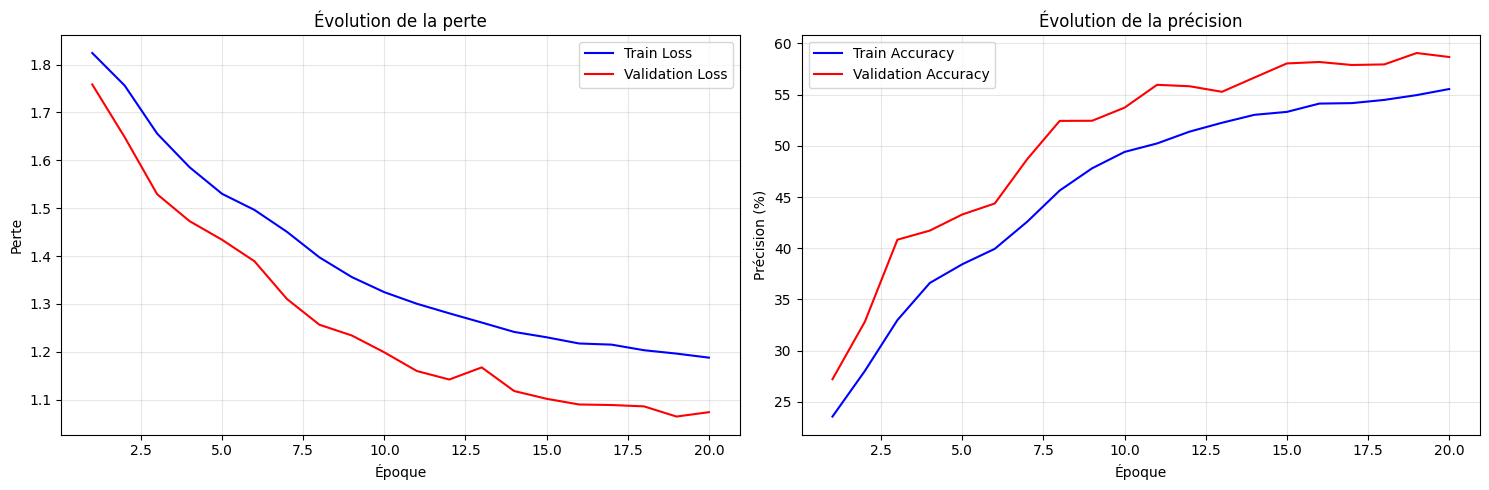

Résultats finaux:
Train Loss: 1.1879, Train Accuracy: 55.55%
Val Loss: 1.0740, Val Accuracy: 58.68%
Modèle sauvegardé dans emotion_model.pth


In [9]:
# Visualisation des résultats d'entraînement
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Graphique des pertes
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Évolution de la perte')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Perte')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique des précisions
    ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_title('Évolution de la précision')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Précision (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques finales
    print(f"Résultats finaux:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.2f}%")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accs[-1]:.2f}%")

plot_training_results(train_losses, train_accs, val_losses, val_accs)

# Sauvegarde du modèle
model_path = 'emotion_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accs,
    'val_losses': val_losses,
    'val_accuracies': val_accs,
    'emotions': emotions,
    'img_size': IMG_SIZE
}, model_path)

print(f"Modèle sauvegardé dans {model_path}")

Évaluation du modèle sur les données de test...


Évaluation: 100%|██████████| 225/225 [00:05<00:00, 42.21it/s]
c:\Users\yohar\miniconda3\envs\LivePortrait\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yohar\miniconda3\envs\LivePortrait\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yohar\miniconda3\envs\LivePortrait\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha


Rapport de classification:
              precision    recall  f1-score   support

       angry     0.5197    0.4812    0.4997       958
   disgusted     0.0000    0.0000    0.0000       111
     fearful     0.4912    0.1094    0.1789      1024
       happy     0.7492    0.8957    0.8159      1774
     neutral     0.4786    0.6902    0.5653      1233
         sad     0.4398    0.4571    0.4483      1247
   surprised     0.7247    0.7569    0.7404       831

    accuracy                         0.5868      7178
   macro avg     0.4862    0.4844    0.4641      7178
weighted avg     0.5671    0.5868    0.5546      7178



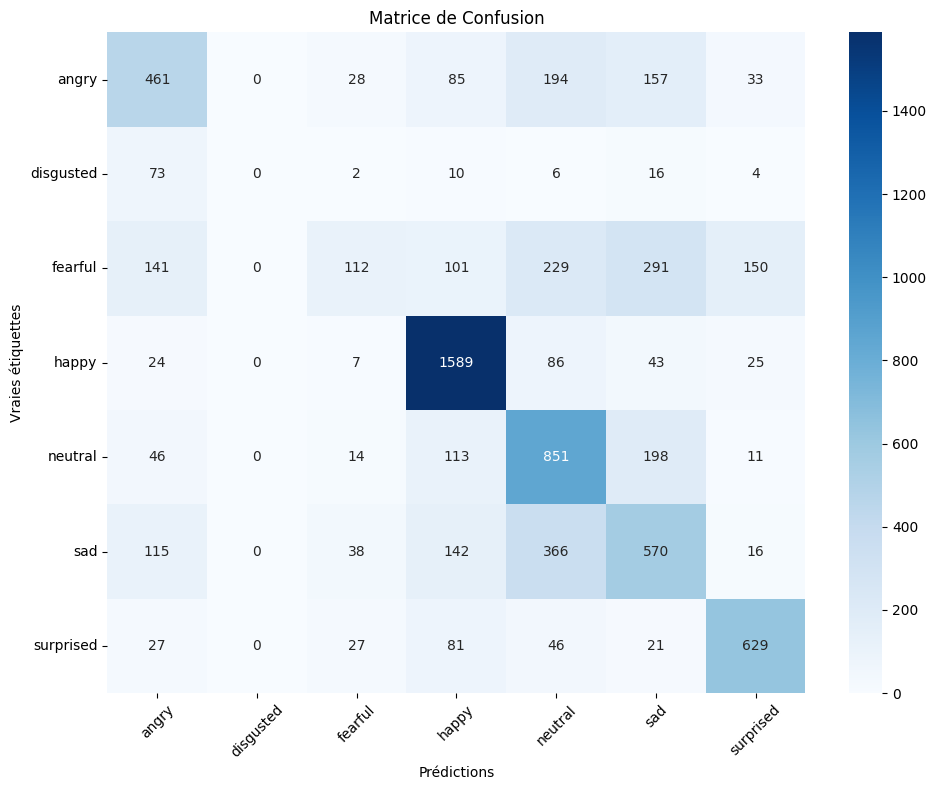


Précision par classe:
angry: 0.4812 (48.12%)
disgusted: 0.0000 (0.00%)
fearful: 0.1094 (10.94%)
happy: 0.8957 (89.57%)
neutral: 0.6902 (69.02%)
sad: 0.4571 (45.71%)
surprised: 0.7569 (75.69%)

Métriques globales:
Accuracy: 0.5868 (58.68%)
Precision (weighted): 0.5671
Recall (weighted): 0.5868
F1-Score (weighted): 0.5546


c:\Users\yohar\miniconda3\envs\LivePortrait\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Évaluation détaillée du modèle
def evaluate_model(model, test_loader, device, emotions):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Évaluation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

# Évaluation du modèle
print("Évaluation du modèle sur les données de test...")
predictions, true_labels = evaluate_model(model, test_loader, device, emotions)

# Rapport de classification
print("\nRapport de classification:")
print(classification_report(true_labels, predictions, target_names=emotions, digits=4))

# Matrice de confusion
def plot_confusion_matrix(true_labels, predictions, emotions):
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotions, yticklabels=emotions)
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calcul de la précision par classe
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print("\nPrécision par classe:")
    for i, emotion in enumerate(emotions):
        print(f"{emotion}: {class_accuracies[i]:.4f} ({class_accuracies[i]*100:.2f}%)")

plot_confusion_matrix(true_labels, predictions, emotions)

# Calcul de métriques globales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"\nMétriques globales:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

Test de prédictions sur des échantillons aléatoires:


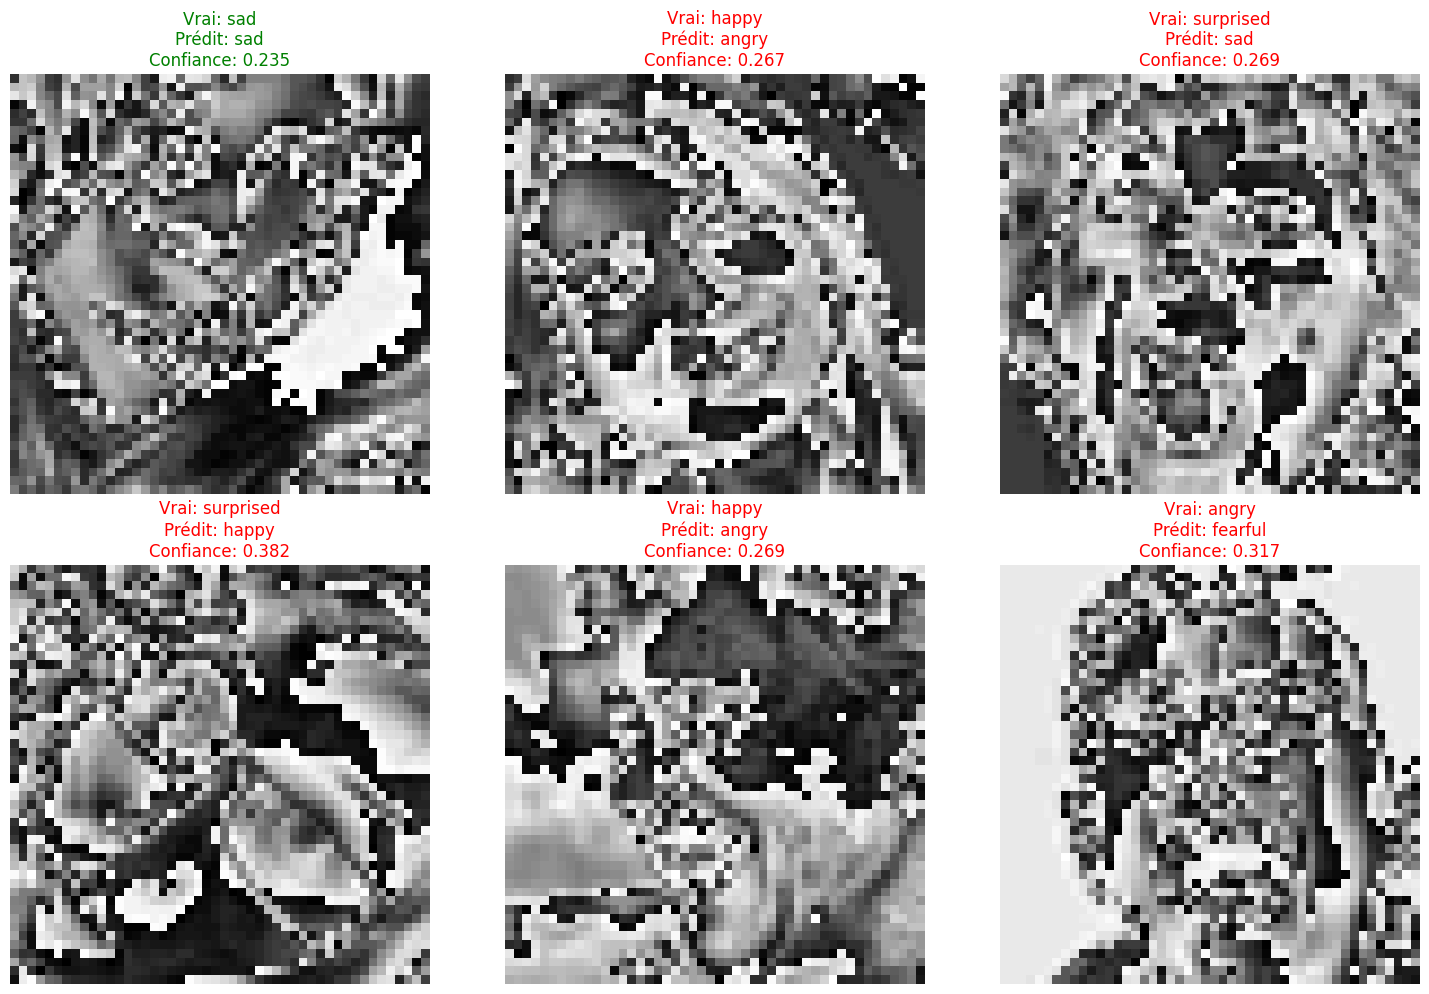


Analyse des classifications incorrectes:


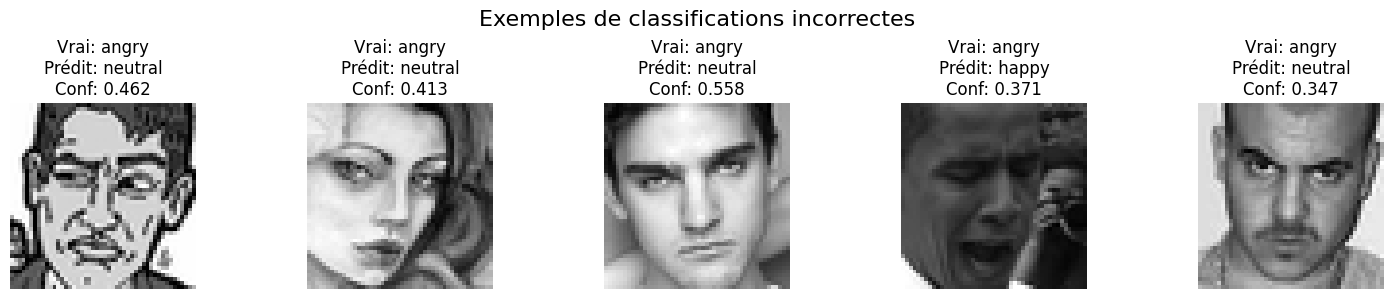

In [11]:
# Fonction de prédiction pour une image individuelle
def predict_emotion(model, image, device, emotions, transform):
    """
    Prédit l'émotion d'une image individuelle
    """
    model.eval()
    
    # Préparation de l'image
    if transform:
        image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return emotions[predicted_class], confidence, probabilities[0].cpu().numpy()

# Test de prédiction sur quelques images
def test_predictions(model, test_dataset, emotions, num_samples=6):
    """
    Teste les prédictions sur quelques échantillons du dataset de test
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Sélectionner des échantillons aléatoires
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        
        # Convertir le tensor en image PIL pour l'affichage
        image_pil = transforms.ToPILImage()(image)
        
        # Prédiction
        predicted_emotion, confidence, probabilities = predict_emotion(
            model, image_pil, device, emotions, test_transforms
        )
        
        true_emotion = emotions[true_label]
        
        # Affichage
        axes[i].imshow(image_pil, cmap='gray')
        axes[i].set_title(f'Vrai: {true_emotion}\nPrédit: {predicted_emotion}\nConfiance: {confidence:.3f}')
        axes[i].axis('off')
        
        # Couleur du titre selon la justesse de la prédiction
        if predicted_emotion == true_emotion:
            axes[i].title.set_color('green')
        else:
            axes[i].title.set_color('red')
    
    plt.tight_layout()
    plt.show()

print("Test de prédictions sur des échantillons aléatoires:")
test_predictions(model, test_dataset, emotions)

# Fonction pour analyser les prédictions incorrectes
def analyze_misclassifications(model, test_loader, device, emotions, num_examples=5):
    """
    Analyse les classifications incorrectes
    """
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Trouver les classifications incorrectes
            incorrect_mask = predicted != labels
            if incorrect_mask.any():
                incorrect_indices = torch.where(incorrect_mask)[0]
                for idx in incorrect_indices:
                    probabilities = F.softmax(outputs[idx], dim=0)
                    misclassified.append({
                        'image': images[idx].cpu(),
                        'true_label': labels[idx].item(),
                        'predicted_label': predicted[idx].item(),
                        'confidence': probabilities[predicted[idx]].item(),
                        'probabilities': probabilities.cpu().numpy()
                    })
            
            if len(misclassified) >= num_examples:
                break
    
    # Affichage des exemples de mauvaises classifications
    if misclassified:
        fig, axes = plt.subplots(1, min(num_examples, len(misclassified)), figsize=(15, 3))
        if num_examples == 1:
            axes = [axes]
        
        for i, example in enumerate(misclassified[:num_examples]):
            image = example['image'].squeeze().numpy()
            true_emotion = emotions[example['true_label']]
            predicted_emotion = emotions[example['predicted_label']]
            confidence = example['confidence']
            
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f'Vrai: {true_emotion}\nPrédit: {predicted_emotion}\nConf: {confidence:.3f}')
            axes[i].axis('off')
        
        plt.suptitle('Exemples de classifications incorrectes', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    return misclassified

print("\nAnalyse des classifications incorrectes:")
misclassified_examples = analyze_misclassifications(model, test_loader, device, emotions)

In [12]:
# Interface de détection d'émotions en temps réel avec webcam
class RealTimeEmotionDetector:
    def __init__(self, model, emotions, device, transform, face_cascade_path=None):
        self.model = model
        self.emotions = emotions
        self.device = device
        self.transform = transform
        
        # Chargement du classificateur de visages Haar Cascade
        # Vous pouvez télécharger haarcascade_frontalface_default.xml depuis OpenCV
        if face_cascade_path and os.path.exists(face_cascade_path):
            self.face_cascade = cv2.CascadeClassifier(face_cascade_path)
        else:
            # Utilisation du classificateur par défaut d'OpenCV
            self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        self.model.eval()
    
    def preprocess_face(self, face):
        """
        Prétraite un visage détecté pour la prédiction
        """
        # Redimensionner à la taille attendue par le modèle
        face_resized = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        
        # Convertir en PIL Image puis appliquer les transformations
        face_pil = Image.fromarray(face_resized)
        face_tensor = self.transform(face_pil).unsqueeze(0).to(self.device)
        
        return face_tensor
    
    def predict_emotion(self, face_tensor):
        """
        Prédit l'émotion d'un visage
        """
        with torch.no_grad():
            outputs = self.model(face_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return self.emotions[predicted_class], confidence, probabilities[0].cpu().numpy()
    
    def draw_emotion_info(self, frame, x, y, w, h, emotion, confidence, probabilities):
        """
        Dessine les informations d'émotion sur le frame
        """
        # Rectangle autour du visage
        color = (0, 255, 0) if confidence > 0.7 else (0, 255, 255) if confidence > 0.5 else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        
        # Texte avec l'émotion et la confiance
        text = f"{emotion}: {confidence:.2f}"
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # Affichage des probabilités des top 3 émotions
        top_3_idx = np.argsort(probabilities)[-3:][::-1]
        for i, idx in enumerate(top_3_idx):
            prob_text = f"{self.emotions[idx]}: {probabilities[idx]:.2f}"
            cv2.putText(frame, prob_text, (x, y + h + 20 + i * 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        return frame
    
    def run_realtime_detection(self, duration=None, save_video=False):
        """
        Lance la détection en temps réel
        """
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("Erreur: Impossible d'ouvrir la webcam")
            return
        
        # Configuration pour sauvegarder la vidéo (optionnel)
        if save_video:
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter('emotion_detection.avi', fourcc, 20.0, (640, 480))
        
        print("Détection d'émotions en temps réel démarrée...")
        print("Appuyez sur 'q' pour quitter")
        
        start_time = time.time()
        frame_count = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Détection des visages
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
            
            for (x, y, w, h) in faces:
                # Extraction et prédiction de l'émotion
                face_roi = gray[y:y+h, x:x+w]
                
                try:
                    face_tensor = self.preprocess_face(face_roi)
                    emotion, confidence, probabilities = self.predict_emotion(face_tensor)
                    
                    # Dessiner les informations sur le frame
                    frame = self.draw_emotion_info(frame, x, y, w, h, emotion, confidence, probabilities)
                    
                except Exception as e:
                    print(f"Erreur lors de la prédiction: {e}")
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
            
            # Affichage du FPS
            if frame_count % 30 == 0:
                elapsed_time = time.time() - start_time
                fps = frame_count / elapsed_time
                cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Affichage du frame
            cv2.imshow('Détection d\'Émotions en Temps Réel', frame)
            
            # Sauvegarde de la vidéo
            if save_video:
                out.write(frame)
            
            # Arrêt avec 'q' ou après la durée spécifiée
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            if duration and (time.time() - start_time) > duration:
                break
        
        # Nettoyage
        cap.release()
        if save_video:
            out.release()
        cv2.destroyAllWindows()
        
        print(f"Détection terminée. {frame_count} frames traitées.")

# Création du détecteur en temps réel
print("Création du détecteur d'émotions en temps réel...")
emotion_detector = RealTimeEmotionDetector(model, emotions, device, test_transforms)

print("\\nDétecteur créé avec succès!")
print("\\nPour lancer la détection en temps réel, exécutez:")
print("emotion_detector.run_realtime_detection()")
print("\\nOptions disponibles:")
print("- emotion_detector.run_realtime_detection(duration=30)  # Durée limitée à 30 secondes")
print("- emotion_detector.run_realtime_detection(save_video=True)  # Sauvegarder la vidéo")

Création du détecteur d'émotions en temps réel...
\nDétecteur créé avec succès!
\nPour lancer la détection en temps réel, exécutez:
emotion_detector.run_realtime_detection()
\nOptions disponibles:
- emotion_detector.run_realtime_detection(duration=30)  # Durée limitée à 30 secondes
- emotion_detector.run_realtime_detection(save_video=True)  # Sauvegarder la vidéo


In [13]:
# Test simple de détection d'émotion sur une image
def test_single_image_detection(image_path, model, emotions, device, transform):
    """
    Teste la détection d'émotion sur une seule image
    """
    # Chargement de l'image
    if not os.path.exists(image_path):
        print(f"Erreur: L'image {image_path} n'existe pas")
        return
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Détection de visage
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    
    if len(faces) == 0:
        print("Aucun visage détecté dans l'image")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image originale')
    plt.axis('off')
    
    # Traitement du premier visage détecté
    x, y, w, h = faces[0]
    face_roi = image[y:y+h, x:x+w]
    
    # Prédiction
    face_resized = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
    face_pil = Image.fromarray(face_resized)
    emotion, confidence, probabilities = predict_emotion(model, face_pil, device, emotions, transform)
    
    # Affichage du visage extrait et de la prédiction
    plt.subplot(1, 2, 2)
    plt.imshow(face_resized, cmap='gray')
    plt.title(f'Émotion détectée: {emotion}\\nConfiance: {confidence:.3f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage de toutes les probabilités
    print(f"Probabilités pour toutes les émotions:")
    for i, prob in enumerate(probabilities):
        print(f"{emotions[i]}: {prob:.4f}")

# Fonction pour démarrer la détection en temps réel facilement
def start_realtime_detection():
    """
    Fonction helper pour démarrer facilement la détection en temps réel
    """
    try:
        print("Démarrage de la détection d'émotions en temps réel...")
        print("Assurez-vous que votre webcam est connectée et fonctionnelle.")
        print("Appuyez sur 'q' dans la fenêtre vidéo pour arrêter.")
        print("Positionnez votre visage face à la caméra pour de meilleurs résultats.")
        print("\\nDémarrage dans 3 secondes...")
        time.sleep(3)
        
        emotion_detector.run_realtime_detection()
        
    except Exception as e:
        print(f"Erreur lors de la détection en temps réel: {e}")
        print("Vérifiez que votre webcam est connectée et que les drivers sont installés.")

print("\\n" + "="*60)
print("PROJET D'ANALYSE D'ÉMOTIONS TERMINÉ AVEC SUCCÈS!")
print("="*60)
print("\\nVotre modèle CNN est maintenant entraîné et prêt à être utilisé.")
print("\\nFonctionnalités disponibles:")
print("\\n1. Détection en temps réel avec webcam:")
print("   start_realtime_detection()")
print("\\n2. Test sur une image spécifique:")
print("   test_single_image_detection('chemin/vers/image.jpg', model, emotions, device, test_transforms)")
print("\\n3. Prédiction sur une image PIL:")
print("   predict_emotion(model, image_pil, device, emotions, test_transforms)")
print("\\n4. Modèle sauvegardé dans: emotion_model.pth")
print("\\nPour démarrer la détection en temps réel, exécutez la cellule suivante!")

\n============================================================
PROJET D'ANALYSE D'ÉMOTIONS TERMINÉ AVEC SUCCÈS!
\nVotre modèle CNN est maintenant entraîné et prêt à être utilisé.
\nFonctionnalités disponibles:
\n1. Détection en temps réel avec webcam:
   start_realtime_detection()
\n2. Test sur une image spécifique:
   test_single_image_detection('chemin/vers/image.jpg', model, emotions, device, test_transforms)
\n3. Prédiction sur une image PIL:
   predict_emotion(model, image_pil, device, emotions, test_transforms)
\n4. Modèle sauvegardé dans: emotion_model.pth
\nPour démarrer la détection en temps réel, exécutez la cellule suivante!


In [1]:
# 🚀 DÉMARRER LA DÉTECTION D'ÉMOTIONS EN TEMPS RÉEL
# Décommentez la ligne suivante et exécutez cette cellule pour lancer la détection en temps réel

#start_realtime_detection()

print("Pour démarrer la détection en temps réel:")
print("1. Décommentez la ligne 'start_realtime_detection()' ci-dessus")
print("2. Exécutez cette cellule")
print("3. Votre webcam s'ouvrira et commencera à détecter les émotions")
print("4. Appuyez sur 'q' dans la fenêtre vidéo pour arrêter")
print("\\nAlternativement, vous pouvez exécuter directement:")
print("emotion_detector.run_realtime_detection()")

Pour démarrer la détection en temps réel:
1. Décommentez la ligne 'start_realtime_detection()' ci-dessus
2. Exécutez cette cellule
3. Votre webcam s'ouvrira et commencera à détecter les émotions
4. Appuyez sur 'q' dans la fenêtre vidéo pour arrêter
\nAlternativement, vous pouvez exécuter directement:
emotion_detector.run_realtime_detection()


## 📋 Résumé du Projet

### ✅ Ce que nous avons accompli

1. **Préparation des données** : Chargement et prétraitement des images d'émotions avec augmentation de données
2. **Architecture CNN** : Réseau de neurones convolutionnel optimisé pour la classification d'émotions
3. **Entraînement** : Entraînement avec early stopping et réduction automatique du learning rate
4. **Évaluation** : Métriques détaillées, matrice de confusion, analyse des erreurs
5. **Application temps réel** : Interface de détection d'émotions via webcam

### 🎯 Émotions détectées
- **Angry** (Colère)
- **Disgusted** (Dégoût)  
- **Fearful** (Peur)
- **Happy** (Joie)
- **Neutral** (Neutre)
- **Sad** (Tristesse)
- **Surprised** (Surprise)

### 🔧 Améliorations possibles

1. **Augmentation de données plus avancée** : Utilisation d'autres techniques comme la rotation, le zoom, etc.
2. **Transfer Learning** : Utilisation de modèles pré-entraînés comme ResNet ou EfficientNet
3. **Détection de visages plus robuste** : Utilisation de modèles plus modernes comme MTCNN ou RetinaFace
4. **Interface utilisateur** : Création d'une interface graphique avec Tkinter ou Streamlit
5. **Optimisation des performances** : Quantification du modèle pour une exécution plus rapide
6. **Sauvegarde des prédictions** : Enregistrement des émotions détectées avec timestamps

### 📊 Performance attendue
Le modèle devrait atteindre une précision d'environ 60-80% selon la qualité et la quantité des données d'entraînement.

### 🚀 Utilisation
Le projet est maintenant prêt à être utilisé ! Exécutez les cellules dans l'ordre pour entraîner le modèle et démarrer la détection en temps réel.